In [1]:
from vizdoom import *
import random
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2 as cv
from skimage import transform

from agent import DQN_agent, params
import torch
from torch.autograd import Variable

def preprocess_frame(frame):
    # Greyscale frame already done in our vizdoom config
    # x = np.mean(frame,-1)
    
    # Crop the screen (remove the roof because it contains no information)
    cropped_frame = frame[30:-10,30:-30]
    
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    
    # Resize
    preprocessed_frame = transform.resize(normalized_frame, [84,84])
    return preprocessed_frame



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

game = DoomGame()
game.load_config("../Udacity/doom/scenarios/basic.cfg")
game.set_screen_format(ScreenFormat.GRAY8)
game.init()

shoot = [0, 0, 1]
left = [1, 0, 0]
right = [0, 1, 0]
actions = [shoot, left, right]

agent = DQN_agent(3, device)

cx = Variable(torch.zeros(64, 256, device=device)) # the cell states of the LSTM are reinitialized to zero
hx = Variable(torch.zeros(64, 256, device=device)) # the hidden states of the LSTM are reinitialized to 
def prepopulate_buffer():
    print("prepopulation start")
    samples_amount=0
    while True:
        game.new_episode()
        while True:
            if samples_amount%1000 ==0:
                print(samples_amount)
            if samples_amount==10000:
                break
            state = game.get_state()
            img = state.screen_buffer
            img = preprocess_frame(img)
            selected_action = agent.select_action(img, 0.95, (hx[0].view(1,-1), cx[0].view(1,-1)))
            action = actions[selected_action]
            reward = game.make_action(action)
            done = game.is_episode_finished()
            if done:
                break
            next_state = game.get_state()
            next_img = next_state.screen_buffer
            next_img = preprocess_frame(next_img)
            agent.memoryBuffer.add(img, selected_action, reward, next_img, done)
            agent.memoryBuffer.add(img, selected_action, reward, next_img, done)
            samples_amount+=2
            state = next_state
        if len(agent.memoryBuffer)%100 ==0:
            print("len = ", len(agent.memoryBuffer))
        if samples_amount==10000:
            break
    print("prepopulation stop")
prepopulate_buffer()

prepopulation start
0


D:\Anaconda\envs\drlnd\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Anaconda\envs\drlnd\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
len =  0
prepopulation stop


In [2]:
episodes = 5000
eps_start=1.0
eps_end=0.01
eps_decay=0.9995
max_steps = 500

epsilon = eps_start

results = []
cx = Variable(torch.zeros(64, 256, device=device)) # the cell states of the LSTM are reinitialized to zero
hx = Variable(torch.zeros(64, 256, device=device)) # the hidden states of the LSTM are reinitialized to 

for i in range(episodes):
    game.new_episode()
    while True:
        state = game.get_state()
        img = state.screen_buffer
        img = preprocess_frame(img)
        misc = state.game_variables
        selected_action = agent.select_action(img, epsilon, (hx[0].view(1,-1), cx[0].view(1,-1)))
        action = actions[selected_action]
        reward = game.make_action(action)
        done = game.is_episode_finished()
        if done:
            cx = Variable(torch.zeros(64, 256, device=device)) # the cell states of the LSTM are reinitialized to zero
            hx = Variable(torch.zeros(64, 256, device=device)) # the hidden states of the LSTM are reinitialized to zero
            break
        else:
            cx = Variable(cx.data) # we keep the old cell states, making sure they are in a torch variable
            hx = Variable(hx.data) # we keep the old hidden states, making sure they are in a torch variable
        next_state = game.get_state()
        next_img = next_state.screen_buffer
        next_img = preprocess_frame(next_img)
        (hx, cx) = agent.step(img, selected_action, reward, next_img, done, hx, cx)
        state = next_state
        #time.sleep(0.02)
    epsilon = epsilon*eps_decay
    if epsilon < eps_end:
        epsilon = eps_end    
    if i%250==0:
        file_name = 'checkpoint_' + str(i) + '.pth'
        torch.save(agent.local_network.state_dict(), file_name)
    results.append(game.get_total_reward())
    print ("    ", i, " result:", game.get_total_reward())

     0  result: -67.0
     1  result: 90.0
     2  result: 94.0
     3  result: -240.0
     4  result: 95.0
     5  result: -52.0
     6  result: -133.0
     7  result: -370.0
     8  result: 92.0
     9  result: 86.0
     10  result: -380.0
     11  result: 48.0
     12  result: -215.0
     13  result: -246.0
     14  result: -33.0
     15  result: -380.0
     16  result: 93.0
     17  result: 95.0
     18  result: 91.0
     19  result: 69.0
     20  result: 94.0
     21  result: -385.0
     22  result: -380.0
     23  result: -81.0
     24  result: 94.0
     25  result: 93.0
     26  result: -380.0
     27  result: -74.0
     28  result: 5.0
     29  result: -375.0
     30  result: -380.0
     31  result: -95.0
     32  result: 95.0
     33  result: 93.0
     34  result: 76.0
     35  result: 23.0
     36  result: -112.0
     37  result: 65.0
     38  result: 95.0
     39  result: 95.0
     40  result: 92.0
     41  result: 95.0
     42  result: -40.0
     43  result: 66.0
     44  r

     354  result: 92.0
     355  result: 76.0
     356  result: 73.0
     357  result: 95.0
     358  result: 46.0
     359  result: -56.0
     360  result: 95.0
     361  result: -375.0
     362  result: 91.0
     363  result: 93.0
     364  result: 95.0
     365  result: 76.0
     366  result: -370.0
     367  result: 91.0
     368  result: 93.0
     369  result: 95.0
     370  result: -22.0
     371  result: 65.0
     372  result: 94.0
     373  result: 23.0
     374  result: 95.0
     375  result: -375.0
     376  result: 24.0
     377  result: 94.0
     378  result: 93.0
     379  result: 94.0
     380  result: -3.0
     381  result: 92.0
     382  result: -2.0
     383  result: 93.0
     384  result: 73.0
     385  result: 61.0
     386  result: 26.0
     387  result: -9.0
     388  result: 70.0
     389  result: -375.0
     390  result: 95.0
     391  result: 75.0
     392  result: 94.0
     393  result: 90.0
     394  result: 94.0
     395  result: 4.0
     396  result: 42.0
  

     707  result: 86.0
     708  result: 53.0
     709  result: 71.0
     710  result: 94.0
     711  result: 47.0
     712  result: 95.0
     713  result: 54.0
     714  result: 93.0
     715  result: 19.0
     716  result: -18.0
     717  result: 93.0
     718  result: 75.0
     719  result: 37.0
     720  result: 68.0
     721  result: 45.0
     722  result: 95.0
     723  result: 75.0
     724  result: 95.0
     725  result: 34.0
     726  result: 92.0
     727  result: 40.0
     728  result: 92.0
     729  result: 95.0
     730  result: 42.0
     731  result: 73.0
     732  result: 10.0
     733  result: 70.0
     734  result: 95.0
     735  result: 94.0
     736  result: 95.0
     737  result: 95.0
     738  result: 95.0
     739  result: 95.0
     740  result: 19.0
     741  result: 26.0
     742  result: 94.0
     743  result: 94.0
     744  result: 15.0
     745  result: 94.0
     746  result: 94.0
     747  result: 95.0
     748  result: 93.0
     749  result: 3.0
     750  r

     1060  result: 92.0
     1061  result: 70.0
     1062  result: 92.0
     1063  result: 93.0
     1064  result: 93.0
     1065  result: 93.0
     1066  result: 63.0
     1067  result: 65.0
     1068  result: 92.0
     1069  result: 75.0
     1070  result: 93.0
     1071  result: 93.0
     1072  result: 94.0
     1073  result: 68.0
     1074  result: 22.0
     1075  result: 32.0
     1076  result: 50.0
     1077  result: 89.0
     1078  result: 93.0
     1079  result: 93.0
     1080  result: 92.0
     1081  result: -375.0
     1082  result: 83.0
     1083  result: 95.0
     1084  result: 68.0
     1085  result: 22.0
     1086  result: 94.0
     1087  result: 93.0
     1088  result: 74.0
     1089  result: 41.0
     1090  result: 19.0
     1091  result: 94.0
     1092  result: 94.0
     1093  result: 94.0
     1094  result: 50.0
     1095  result: 68.0
     1096  result: 88.0
     1097  result: 93.0
     1098  result: 49.0
     1099  result: 93.0
     1100  result: 40.0
     1101  res

     1402  result: 92.0
     1403  result: 94.0
     1404  result: 94.0
     1405  result: 94.0
     1406  result: 65.0
     1407  result: 93.0
     1408  result: 63.0
     1409  result: 95.0
     1410  result: 50.0
     1411  result: 94.0
     1412  result: 12.0
     1413  result: 94.0
     1414  result: 92.0
     1415  result: 69.0
     1416  result: 93.0
     1417  result: 93.0
     1418  result: 95.0
     1419  result: 94.0
     1420  result: 94.0
     1421  result: 93.0
     1422  result: 32.0
     1423  result: 85.0
     1424  result: 72.0
     1425  result: 46.0
     1426  result: 55.0
     1427  result: 95.0
     1428  result: 90.0
     1429  result: 95.0
     1430  result: 34.0
     1431  result: 92.0
     1432  result: 94.0
     1433  result: 68.0
     1434  result: 91.0
     1435  result: 94.0
     1436  result: 29.0
     1437  result: 90.0
     1438  result: 59.0
     1439  result: 65.0
     1440  result: 92.0
     1441  result: 46.0
     1442  result: 90.0
     1443  resul

     1744  result: 86.0
     1745  result: 44.0
     1746  result: 53.0
     1747  result: 92.0
     1748  result: 94.0
     1749  result: 19.0
     1750  result: 95.0
     1751  result: 93.0
     1752  result: 57.0
     1753  result: 94.0
     1754  result: 43.0
     1755  result: 68.0
     1756  result: 94.0
     1757  result: 94.0
     1758  result: 93.0
     1759  result: 55.0
     1760  result: 94.0
     1761  result: 93.0
     1762  result: 93.0
     1763  result: 93.0
     1764  result: 94.0
     1765  result: 93.0
     1766  result: 54.0
     1767  result: 45.0
     1768  result: 65.0
     1769  result: 71.0
     1770  result: 91.0
     1771  result: 42.0
     1772  result: 66.0
     1773  result: 55.0
     1774  result: 72.0
     1775  result: 91.0
     1776  result: 83.0
     1777  result: 93.0
     1778  result: 92.0
     1779  result: 66.0
     1780  result: 94.0
     1781  result: 93.0
     1782  result: 44.0
     1783  result: 93.0
     1784  result: 49.0
     1785  resul

     2086  result: 93.0
     2087  result: 38.0
     2088  result: 58.0
     2089  result: 93.0
     2090  result: 93.0
     2091  result: 28.0
     2092  result: 34.0
     2093  result: 92.0
     2094  result: 95.0
     2095  result: 43.0
     2096  result: 71.0
     2097  result: 93.0
     2098  result: 74.0
     2099  result: 93.0
     2100  result: 92.0
     2101  result: 73.0
     2102  result: 70.0
     2103  result: 95.0
     2104  result: 71.0
     2105  result: 58.0
     2106  result: 40.0
     2107  result: 95.0
     2108  result: 81.0
     2109  result: 64.0
     2110  result: 94.0
     2111  result: 93.0
     2112  result: 92.0
     2113  result: 59.0
     2114  result: 85.0
     2115  result: 94.0
     2116  result: 63.0
     2117  result: 93.0
     2118  result: 95.0
     2119  result: 94.0
     2120  result: 51.0
     2121  result: 95.0
     2122  result: 95.0
     2123  result: 78.0
     2124  result: 91.0
     2125  result: 93.0
     2126  result: 93.0
     2127  resul

     2428  result: 44.0
     2429  result: 94.0
     2430  result: 58.0
     2431  result: 83.0
     2432  result: 94.0
     2433  result: 69.0
     2434  result: 59.0
     2435  result: 67.0
     2436  result: 82.0
     2437  result: 93.0
     2438  result: 70.0
     2439  result: 93.0
     2440  result: 95.0
     2441  result: 70.0
     2442  result: 70.0
     2443  result: 78.0
     2444  result: 39.0
     2445  result: 65.0
     2446  result: 90.0
     2447  result: 92.0
     2448  result: 93.0
     2449  result: 93.0
     2450  result: 72.0
     2451  result: 84.0
     2452  result: 65.0
     2453  result: 92.0
     2454  result: 93.0
     2455  result: 62.0
     2456  result: 62.0
     2457  result: 92.0
     2458  result: 93.0
     2459  result: 93.0
     2460  result: 93.0
     2461  result: 95.0
     2462  result: 92.0
     2463  result: 93.0
     2464  result: 92.0
     2465  result: 94.0
     2466  result: 69.0
     2467  result: 92.0
     2468  result: 67.0
     2469  resul

     2770  result: 75.0
     2771  result: 59.0
     2772  result: 62.0
     2773  result: 50.0
     2774  result: 91.0
     2775  result: 92.0
     2776  result: 75.0
     2777  result: 71.0
     2778  result: 93.0
     2779  result: 94.0
     2780  result: 92.0
     2781  result: 94.0
     2782  result: 75.0
     2783  result: 62.0
     2784  result: 46.0
     2785  result: 94.0
     2786  result: 49.0
     2787  result: 68.0
     2788  result: 94.0
     2789  result: 60.0
     2790  result: 81.0
     2791  result: 94.0
     2792  result: 51.0
     2793  result: 92.0
     2794  result: 95.0
     2795  result: 94.0
     2796  result: 94.0
     2797  result: 94.0
     2798  result: 68.0
     2799  result: 56.0
     2800  result: 68.0
     2801  result: 94.0
     2802  result: 79.0
     2803  result: 53.0
     2804  result: 94.0
     2805  result: 94.0
     2806  result: 95.0
     2807  result: 92.0
     2808  result: 90.0
     2809  result: 95.0
     2810  result: 94.0
     2811  resul

     3113  result: 94.0
     3114  result: 93.0
     3115  result: 47.0
     3116  result: 94.0
     3117  result: 64.0
     3118  result: 46.0
     3119  result: 64.0
     3120  result: 94.0
     3121  result: 94.0
     3122  result: 94.0
     3123  result: 76.0
     3124  result: 94.0
     3125  result: 68.0
     3126  result: 94.0
     3127  result: 94.0
     3128  result: 72.0
     3129  result: 94.0
     3130  result: 93.0
     3131  result: 94.0
     3132  result: 94.0
     3133  result: 95.0
     3134  result: 92.0
     3135  result: 93.0
     3136  result: 95.0
     3137  result: 14.0
     3138  result: 72.0
     3139  result: 94.0
     3140  result: 93.0
     3141  result: 94.0
     3142  result: 50.0
     3143  result: 65.0
     3144  result: 95.0
     3145  result: 94.0
     3146  result: 86.0
     3147  result: 94.0
     3148  result: 94.0
     3149  result: 71.0
     3150  result: 92.0
     3151  result: 87.0
     3152  result: 93.0
     3153  result: 91.0
     3154  resul

     3455  result: 89.0
     3456  result: 92.0
     3457  result: 93.0
     3458  result: 93.0
     3459  result: 92.0
     3460  result: 57.0
     3461  result: 93.0
     3462  result: 92.0
     3463  result: 93.0
     3464  result: 94.0
     3465  result: 94.0
     3466  result: 94.0
     3467  result: 94.0
     3468  result: 94.0
     3469  result: 52.0
     3470  result: 94.0
     3471  result: 70.0
     3472  result: 53.0
     3473  result: 94.0
     3474  result: 74.0
     3475  result: 94.0
     3476  result: 71.0
     3477  result: 81.0
     3478  result: 94.0
     3479  result: 74.0
     3480  result: 81.0
     3481  result: 65.0
     3482  result: 63.0
     3483  result: 62.0
     3484  result: 94.0
     3485  result: 94.0
     3486  result: 94.0
     3487  result: 59.0
     3488  result: 65.0
     3489  result: 89.0
     3490  result: 86.0
     3491  result: 94.0
     3492  result: 94.0
     3493  result: 94.0
     3494  result: 83.0
     3495  result: 94.0
     3496  resul

     3798  result: 91.0
     3799  result: 94.0
     3800  result: 95.0
     3801  result: 71.0
     3802  result: 94.0
     3803  result: 61.0
     3804  result: 75.0
     3805  result: 94.0
     3806  result: 39.0
     3807  result: 94.0
     3808  result: 95.0
     3809  result: 94.0
     3810  result: 65.0
     3811  result: 65.0
     3812  result: 93.0
     3813  result: 91.0
     3814  result: 56.0
     3815  result: 76.0
     3816  result: 69.0
     3817  result: 74.0
     3818  result: 71.0
     3819  result: 94.0
     3820  result: 59.0
     3821  result: 94.0
     3822  result: 73.0
     3823  result: 95.0
     3824  result: 59.0
     3825  result: 94.0
     3826  result: 86.0
     3827  result: 94.0
     3828  result: 63.0
     3829  result: 72.0
     3830  result: 94.0
     3831  result: 94.0
     3832  result: 94.0
     3833  result: 91.0
     3834  result: 71.0
     3835  result: 93.0
     3836  result: 94.0
     3837  result: 94.0
     3838  result: 95.0
     3839  resul

     4140  result: 63.0
     4141  result: 94.0
     4142  result: 94.0
     4143  result: 94.0
     4144  result: 33.0
     4145  result: 94.0
     4146  result: 94.0
     4147  result: 94.0
     4148  result: 77.0
     4149  result: 94.0
     4150  result: 73.0
     4151  result: 63.0
     4152  result: 94.0
     4153  result: 94.0
     4154  result: 91.0
     4155  result: 94.0
     4156  result: 92.0
     4157  result: 70.0
     4158  result: 65.0
     4159  result: 94.0
     4160  result: 59.0
     4161  result: 90.0
     4162  result: 59.0
     4163  result: 94.0
     4164  result: 54.0
     4165  result: 95.0
     4166  result: 94.0
     4167  result: 94.0
     4168  result: 94.0
     4169  result: 94.0
     4170  result: 95.0
     4171  result: 94.0
     4172  result: 77.0
     4173  result: 94.0
     4174  result: 94.0
     4175  result: 57.0
     4176  result: 94.0
     4177  result: 95.0
     4178  result: 94.0
     4179  result: 94.0
     4180  result: 69.0
     4181  resul

     4483  result: 94.0
     4484  result: 90.0
     4485  result: 94.0
     4486  result: 94.0
     4487  result: 75.0
     4488  result: 94.0
     4489  result: 81.0
     4490  result: 45.0
     4491  result: 94.0
     4492  result: 94.0
     4493  result: 92.0
     4494  result: 94.0
     4495  result: 94.0
     4496  result: 94.0
     4497  result: 94.0
     4498  result: 95.0
     4499  result: 94.0
     4500  result: 71.0
     4501  result: 79.0
     4502  result: 86.0
     4503  result: 94.0
     4504  result: 94.0
     4505  result: 93.0
     4506  result: 60.0
     4507  result: 94.0
     4508  result: 94.0
     4509  result: 94.0
     4510  result: 94.0
     4511  result: 75.0
     4512  result: 94.0
     4513  result: 94.0
     4514  result: 82.0
     4515  result: 32.0
     4516  result: 94.0
     4517  result: 94.0
     4518  result: 56.0
     4519  result: 75.0
     4520  result: 66.0
     4521  result: 94.0
     4522  result: 57.0
     4523  result: 94.0
     4524  resul

     4826  result: 94.0
     4827  result: 94.0
     4828  result: 81.0
     4829  result: 94.0
     4830  result: 85.0
     4831  result: 59.0
     4832  result: 94.0
     4833  result: 94.0
     4834  result: 94.0
     4835  result: 94.0
     4836  result: 49.0
     4837  result: 94.0
     4838  result: 94.0
     4839  result: 94.0
     4840  result: 93.0
     4841  result: 94.0
     4842  result: 75.0
     4843  result: 94.0
     4844  result: 94.0
     4845  result: 94.0
     4846  result: 56.0
     4847  result: 71.0
     4848  result: 94.0
     4849  result: 67.0
     4850  result: 94.0
     4851  result: 94.0
     4852  result: 94.0
     4853  result: 94.0
     4854  result: 94.0
     4855  result: 72.0
     4856  result: 43.0
     4857  result: 94.0
     4858  result: 94.0
     4859  result: 52.0
     4860  result: 72.0
     4861  result: 69.0
     4862  result: 94.0
     4863  result: 63.0
     4864  result: 94.0
     4865  result: 68.0
     4866  result: 58.0
     4867  resul

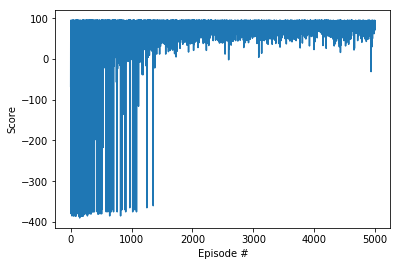

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(results)), results)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()